# 基于OpenMMLab Segmentation模型库训练细胞划痕检测模型
---

### 关于

- 基于同济子豪兄提供的开源教程：https://github.com/TommyZihao/MMSegmentation_Tutorials
- OpenMMLab模型库：https://platform.openmmlab.com/modelzoo/
- MMSegmentation：https://github.com/open-mmlab/mmsegmentation
- 官方文档：https://mmsegmentation.readthedocs.io/en/latest/
- 云GPU平台：https://featurize.cn?s=b291c33c5f044ec59c9bc25b9f55edb9

## 一、安装和配置MMsegmentation
---

### 1.安装Pytorch

In [3]:
# https://pytorch.org
# !pip3 install install torch==1.10.1+cu113 torchvision==0.11.2+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html
# 由于云计算平台已经自动安装了，所以可以直接检查
import torch
torch.__version__

'1.10.0+cu113'

### 2.用MIM安装MMCV

In [ ]:
!pip install -U openmim
!mim install mmengine
!mim install mmcv==2.0.0

### 3.安装其它工具包

In [ ]:
!pip install opencv-python pillow matplotlib seaborn tqdm pytorch-lightning 'mmdet>=3.1.0' -i https://pypi.tuna.tsinghua.edu.cn/simple
# !pip install setuptools==59.5 prettytable

### 4.下载 MMSegmentation

In [12]:
# 如果需要，删掉原有的 mmsegmentation 文件夹（慎重）
!rm -rf mmsegmentation

In [ ]:
# 从 github 上下载 mmsegmentation 源代码，使用v1.1.2版本

!git clone https://github.com/open-mmlab/mmsegmentation.git -b v1.1.2

# !git clone https://github.com/open-mmlab/mmsegmentation.git -b v1.2.0

### 5.安装 MMSegmentation

In [14]:
# 进入下载文件目录
import os
os.chdir('mmsegmentation')

In [ ]:
# 安装
!pip install -v -e .

### 6.检查安装成功

In [16]:
# 检查 Pytorch
import torch, torchvision
print('Pytorch 版本', torch.__version__)
print('CUDA 是否可用',torch.cuda.is_available())

Pytorch 版本 1.10.0+cu113
CUDA 是否可用 True


In [17]:
# 检查 mmcv
import mmcv
from mmcv.ops import get_compiling_cuda_version, get_compiler_version
print('MMCV版本', mmcv.__version__)
print('CUDA版本', get_compiling_cuda_version())
print('编译器版本', get_compiler_version())

MMCV版本 2.0.0
CUDA版本 11.3
编译器版本 GCC 9.3


In [18]:
# 检查 mmsegmentation
import mmseg
from mmseg.utils import register_all_modules
from mmseg.apis import inference_model, init_model
print('mmsegmentation版本', mmseg.__version__)

mmsegmentation版本 1.1.2


## 二、创建工作目录
---

In [48]:
# 数据集目录
#os.mkdir('../DataSets')

# 个人配置文件目录
#os.mkdir('../YuYuan_Configs')

# 训练结果目录
#os.mkdir('../YuYuan_Models')

# 测试数据目录
#os.mkdir('../TestData')

# 其他结果输出目录
#os.mkdir('../Outputs')

## 三、使用预训练模型进行预测
---

### 1.设定工作目录

In [3]:
# 获得当前工作目录，也可以用os.getcwd()。上级目录用“..”作为参数
import os
current_Path='.'
parent_Path='..'
os.path.abspath(current_Path)

#os.getcwd()

'/home/featurize/work'

In [4]:
os.chdir('mmsegmentation')

In [5]:
os.getcwd()

'/home/featurize/work/mmsegmentation'

### 2.准备图片素材

In [43]:
# 下载图片到TestData目录下
!wget [http://xxxxxxxxxxxxxxxx] -P TestData

# 我这里直接手动上传一些资料

zsh:1: no matches found: [http://xxxxxxxxxxxxxxxx]


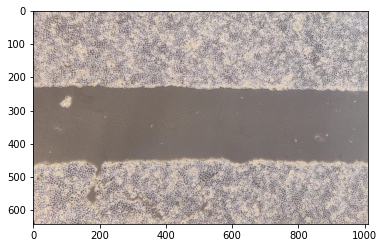

In [34]:
# 预览图片
import cv2
import matplotlib.pyplot as plt 

img_path='/home/featurize/work/TestData/Camera_XHS_17132849488291000g0082dfvvg4ah20cg49u9eftmlgrp4864vdo.jpg'
img_bgr = cv2.imread(img_path)
plt.figure()
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

### 3.载入预训练模型
Model Zoo：https://github.com/open-mmlab/mmsegmentation/tree/main#benchmark-and-model-zoo

In [69]:
os.getcwd()

'/home/featurize/work/mmsegmentation'

In [8]:
# 模型 config 配置文件(目前位于mmsegmentation目录中)
config_file = '/home/featurize/work/YuYuan_Results/Scratch_Test_KNet.py'  # 主要是需要其中的pipline方法

# 模型 checkpoint 权重文件
checkpoint_file = '/home/featurize/work/YuYuan_Results/best_mIoU_iter_1500.pth'  # 模型权重文件

# device = 'cpu'
device = 'cuda:0'

In [ ]:
from mmseg.apis import init_model

In [15]:
# 载入模型
model = init_model(config_file, checkpoint_file, device=device)

Loads checkpoint by local backend from path: /home/featurize/work/YuYuan_Results/best_mIoU_iter_1500.pth


### 4.使用模型进行推理

In [13]:
from mmseg.apis import inference_model

In [16]:
# 获得推理结果
result = inference_model(model, img_bgr)
result.keys()

['pred_sem_seg', 'seg_logits']

- pred_sem_seg：定性分析结果，为分类标注mask矩阵
- seg_logits：定量分析结果

In [17]:
# 取得预测mask
pred_mask = result.pred_sem_seg.data[0].cpu().numpy()
pred_mask.shape

(642, 1010)

In [18]:
img_bgr.shape

(642, 1010, 3)

### 5.可视化预测结果

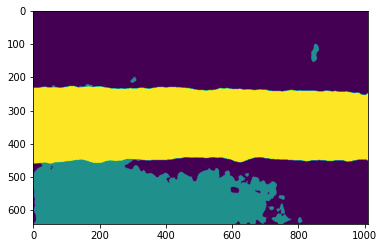

In [35]:
plt.figure()
plt.imshow(pred_mask)
plt.savefig('/home/featurize/work/Outputs/K1-0.jpg') # 保存结果
plt.show()

## 四、准备训练数据集
---

### 1.使用labelme进行标注

- 推荐用`pip install labelme`在本地进行安装
- 将.json标注文件转换为.png格式的mask文件
- 按一定比例分配train和val

### 2.上传本地准备好的数据集

文件结构必须如下，包括：注释mask（ann_dir），原图（img_dir），其中包括训练集（train），测试集（val）

- scrath_dataset
    - ann_dir
        - train
            1. xxx.png
            2. yyy.png
        - val
            3. zzz.png
    - img_dir
        - train
            1. xxx.tif
            2. yyy.tif
        - val
            3. zzz.tif

### 3.删除多余文件

In [25]:
# 进入根目录
os.chdir('/home')

In [27]:
os.getcwd()

'/home'

In [28]:
!find . -iname '__MACOSX'

In [29]:
!find . -iname '.DS_Store'

In [30]:
!find . -iname '.ipynb_checkpoints'

./featurize/.ipynb_checkpoints
./featurize/data/scrath_dataset/.ipynb_checkpoints
./featurize/work/.ipynb_checkpoints
./featurize/work/YuYuan_Configs/.ipynb_checkpoints
./featurize/work/work_dirs/.ipynb_checkpoints
./featurize/work/Outputs/.ipynb_checkpoints
./featurize/work/YuYuan_Results/.ipynb_checkpoints
./featurize/work/YuYuan_Results/Scratch-KNet-20240416/.ipynb_checkpoints


In [31]:
!for i in `find . -iname '__MACOSX'`; do rm -rf $i;done
!for i in `find . -iname '.DS_Store'`; do rm -rf $i;done
!for i in `find . -iname '.ipynb_checkpoints'`; do rm -rf $i;done

## 五、检查训练数据集
---

In [32]:
os.chdir('/home/featurize/work/mmsegmentation')

In [33]:
os.getcwd()

'/home/featurize/work/mmsegmentation'

In [109]:
# 任意选择一张图片（由于位于data目录，这里使用了绝对路径）
img_path = '/home/featurize/data/scrath_dataset/img_dir/train/1 (1).tif'
mask_path = '/home/featurize/data/scrath_dataset/ann_dir/train/1 (1).png'

In [81]:
img = cv2.imread(img_path)
mask = cv2.imread(mask_path)

In [83]:
img.shape

(1824, 2736, 3)

In [87]:
# mask 语义分割标注，与原图大小相同
mask.shape #虽然是3个通道，但是rgb都是标注分类int

(1824, 2736, 3)

In [89]:
# 查看标注分类的种类数
import numpy as np
np.unique(mask)

array([0, 1, 2], dtype=uint8)

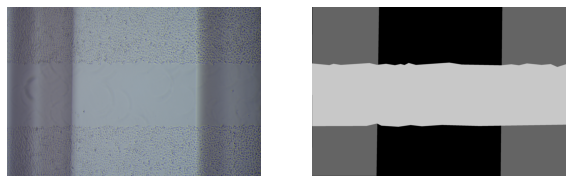

In [108]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(10,5))

ax=axes[0]
ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax.axis('off')

ax=axes[1]
ax.imshow(mask*100)
ax.axis('off')

plt.show()

## 六、生成训练配置文件
---

### 1.创建配置文件

保存到`YuYuan_Configs`目录下，如：`Scratch_Test_config_240417.py`

In [ ]:
# 不要在jupyter中执行该代码块
'''
from mmseg.registry import DATASETS
from .basesegdataset import BaseSegDataset   #继承自BaseSegDataset，所以其实也可以直接修改BaseSegDataset，但是不建议

@DATASETS.register_module()
class ScratchDataset(BaseSegDataset):
    # 类别和对应的 RGB配色
    METAINFO = {
        'classes':['background', 'mark', 'scratch'],    #划痕检测的标注
        'palette':[[127,127,127], [200,0,0], [0,200,0]]
    }
    
    # 指定图像扩展名、标注扩展名
    def __init__(self,
                 seg_map_suffix='.png',   # 标注mask图像的格式
                 img_suffix='.tif',       # 标注img图像的格式
                 reduce_zero_label=False, # 类别ID为0的类别是否需要除去
                 **kwargs) -> None:
        super().__init__(
            seg_map_suffix=seg_map_suffix,
            img_suffix=img_suffix,
            reduce_zero_label=reduce_zero_label,
            **kwargs)
'''

### 2.将配置文件复制到`mmsegmentation/mmseg/datasets`

In [116]:
import shutil
import os

config_name = 'Scratch_Test_config_240417.py'
config_path = f'/home/featurize/work/YuYuan_Configs/{config_name}'
target_dir = '/home/featurize/work/mmsegmentation/mmseg/datasets'

# 构造目标文件的路径
target_file_path = os.path.join(target_dir, config_name)

# 复制文件
shutil.copy(config_path, target_file_path)

print(f"已将 '{config_name}' 复制到 '{target_dir}' 目录中。")

已将 'Scratch_Test_config_240417.py' 复制到 '/home/featurize/work/mmsegmentation/mmseg/datasets' 目录中。


### 3.修改`__init__.py`，以注册配置文件
- 将该文件复制到：`work/mmsegmentation/mmseg/datasets`目录下
- 在`mmseg/datasets/__init__.py`中，添加我们刚刚定义的`Scratch_Test_config_240417.py`中的`ScratchDataset`类

In [ ]:
# 添加引用 Scratch_Test_config_240417.py
'''
from .Scratch_Test_config_240417 import ScratchDataset
'''
# 在__all__ = 中添加ScratchDataset类名称
'''
__all__ = [
    'BaseSegDataset', 'BioMedical3DRandomCrop', 'BioMedical3DRandomFlip',
    'CityscapesDataset', 'PascalVOCDataset', 'ADE20KDataset',
    'PascalContextDataset', 'PascalContextDataset59', 'ChaseDB1Dataset',
    'DRIVEDataset', 'HRFDataset', 'STAREDataset', 'DarkZurichDataset',
    'NightDrivingDataset', 'COCOStuffDataset', 'LoveDADataset',
    'MultiImageMixDataset', 'iSAIDDataset', 'ISPRSDataset', 'PotsdamDataset',
    'LoadAnnotations', 'RandomCrop', 'SegRescale', 'PhotoMetricDistortion',
    'RandomRotate', 'AdjustGamma', 'CLAHE', 'Rerange', 'RGB2Gray',
    'RandomCutOut', 'RandomMosaic', 'PackSegInputs', 'ResizeToMultiple',
    'LoadImageFromNDArray', 'LoadBiomedicalImageFromFile',
    'LoadBiomedicalAnnotation', 'LoadBiomedicalData', 'GenerateEdge',
    'DecathlonDataset', 'LIPDataset', 'ResizeShortestEdge',
    'BioMedicalGaussianNoise', 'BioMedicalGaussianBlur',
    'BioMedicalRandomGamma', 'BioMedical3DPad', 'RandomRotFlip',
    'SynapseDataset', 'REFUGEDataset', 'MapillaryDataset_v1',
    'MapillaryDataset_v2', 'Albu', 'LEVIRCDDataset',
    'LoadMultipleRSImageFromFile', 'LoadSingleRSImageFromFile',
    'ConcatCDInput', 'BaseCDDataset', 'DSDLSegDataset', 'BDD100KDataset',
    'NYUDataset','ScratchDataset' #加在末尾
]
'''

## 七、生成pipeline配置文件
---

处理：数据集路径、预处理、后处理、DataLoader、测试集评估指标，存在于`/home/featurize/work/mmsegmentation/configs/_base_/datasets`目录下

### 1.生成pipline配置文件
保存到`YuYuan_Configs`目录下，如：`Scratch_Test_pipline_240417.py`

In [ ]:
# 参考同济子豪兄 2023-6-28
'''
# 数据处理 pipeline

# 数据集路径
dataset_type = 'ScratchDataset' # 数据集类名
data_root = '../../data/scrath_dataset/' # 数据集路径（相对于mmsegmentation主目录）

# 输入模型的图像裁剪尺寸，一般是 128 的倍数，越小显存开销越少
crop_size = (512, 512)

# 训练预处理
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(
        type='RandomResize',
        scale=(2048, 1024),
        ratio_range=(0.5, 2.0),
        keep_ratio=True),
    dict(type='RandomCrop', crop_size=crop_size, cat_max_ratio=0.75),
    dict(type='RandomFlip', prob=0.5),
    dict(type='PhotoMetricDistortion'),
    dict(type='PackSegInputs')
]

# 测试预处理
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='Resize', scale=(2048, 1024), keep_ratio=True),
    dict(type='LoadAnnotations'),
    dict(type='PackSegInputs')
]

# TTA后处理
img_ratios = [0.5, 0.75, 1.0, 1.25, 1.5, 1.75]
tta_pipeline = [
    dict(type='LoadImageFromFile', file_client_args=dict(backend='disk')),
    dict(
        type='TestTimeAug',
        transforms=[
            [
                dict(type='Resize', scale_factor=r, keep_ratio=True)
                for r in img_ratios
            ],
            [
                dict(type='RandomFlip', prob=0., direction='horizontal'),
                dict(type='RandomFlip', prob=1., direction='horizontal')
            ], [dict(type='LoadAnnotations')], [dict(type='PackSegInputs')]
        ])
]

# 训练 Dataloader
train_dataloader = dict(
    batch_size=2,
    num_workers=2,
    persistent_workers=True,
    sampler=dict(type='InfiniteSampler', shuffle=True),
    dataset=dict(
        type=dataset_type,
        data_root=data_root,
        data_prefix=dict(
            img_path='img_dir/train', seg_map_path='ann_dir/train'),
        pipeline=train_pipeline))

# 验证 Dataloader
val_dataloader = dict(
    batch_size=1,
    num_workers=4,
    persistent_workers=True,
    sampler=dict(type='DefaultSampler', shuffle=False),
    dataset=dict(
        type=dataset_type,
        data_root=data_root,
        data_prefix=dict(
            img_path='img_dir/val', seg_map_path='ann_dir/val'),
        pipeline=test_pipeline))

# 测试 Dataloader
test_dataloader = val_dataloader

# 验证 Evaluator
val_evaluator = dict(type='IoUMetric', iou_metrics=['mIoU', 'mDice', 'mFscore'])

# 测试 Evaluator
test_evaluator = val_evaluator

'''

### 2.将配置文件复制到`mmsegmentation/configs/_base_/datasets`

In [118]:
import shutil
import os

config_name = 'Scratch_Test_pipline_240417.py'
config_path = f'/home/featurize/work/YuYuan_Configs/{config_name}'
target_dir = '/home/featurize/work/mmsegmentation/configs/_base_/datasets'

# 构造目标文件的路径
target_file_path = os.path.join(target_dir, config_name)

# 复制文件
shutil.copy(config_path, target_file_path)

print(f"已将 '{config_name}' 复制到 '{target_dir}' 目录中。")

已将 'Scratch_Test_pipline_240417.py' 复制到 '/home/featurize/work/mmsegmentation/configs/_base_/datasets' 目录中。


### 八、根据不同的神经网络算法生成配置文件
---

### 1.载入模型配置文件

In [122]:
# 进入mmsegmentation目录
import os
#os.chdir('mmsegmentation')
os.getcwd()

'/home/featurize/work/mmsegmentation'

In [125]:
from mmengine import Config

# 根据需要的模型，载入对应的模型配置文件，这里使用KNet
cfg = Config.fromfile('./configs/knet/knet-s3_swin-l_upernet_8xb2-adamw-80k_ade20k-512x512.py')

# 载入刚才配置的pipline文件
dataset_cfg = Config.fromfile('./configs/_base_/datasets/Scratch_Test_pipline_240417.py')

cfg.merge_from_dict(dataset_cfg)

### 2.修改模型的配置文件

In [131]:
# 类别个数
NUM_CLASS = 3

# 单卡训练时，需要把 SyncBN 改成 BN
cfg.norm_cfg = dict(type='BN', requires_grad=True) # 只使用GPU时，BN取代SyncBN
cfg.model.data_preprocessor.size = cfg.crop_size

# 模型 decode/auxiliary 输出头，指定为类别个数
# cfg.model.decode_head.num_classes = NUM_CLASS
cfg.model.decode_head.kernel_generate_head.num_classes = NUM_CLASS
cfg.model.auxiliary_head.num_classes = NUM_CLASS

# 训练 Batch Size
cfg.train_dataloader.batch_size = 3

# 训练结果（日志、权重文件）保存目录
project_name='test'
cfg.work_dir = '/home/featurize/work/YuYuan_Results/{project_name}'

cfg.train_cfg.max_iters = 2000 # 训练迭代次数
cfg.train_cfg.val_interval = 500 # 评估模型间隔
cfg.default_hooks.logger.interval = 100 # 日志记录间隔
cfg.default_hooks.checkpoint.interval = 2500 # 模型权重保存间隔
cfg.default_hooks.checkpoint.max_keep_ckpts = 2 # 最多保留几个模型权重
cfg.default_hooks.checkpoint.save_best = 'mIoU' # 保留指标最高的模型权重

# 随机数种子
cfg['randomness'] = dict(seed=0)

### 3.查看完整config配置

In [132]:
# print(cfg.pretty_text)

### 4.将文件保存到`YuYuan_Configs`

In [133]:
cfg.dump('/home/featurize/work/YuYuan_Configs/Scratch_Test_KNet.py')

## 八、训练模型
---

### 方式一：在命令行中运行（推荐）

进入mmsegmentation工作目录：`cd mmsegmentation`

运行train.py，传入带模型类型的配置文件作为参数：`python tools/train.py /home/featurize/work/YuYuan_Configs/Scratch_Test_KNet.py`
```

### 方式二：在jupyter中运行（其实还是terminal）

In [ ]:
# 进入MMSegmentation主目录
import os
#os.chdir('mmsegmentation')
os.getcwd()

In [ ]:
# 开始训练
!python tools/train.py /home/featurize/work/YuYuan_Configs/Scratch_Test_KNet.py

## 九、写在最后
---

### 1.报错
- 如果遇到报错CUDA out of memeory，可尝试以下步骤：
    - 调小 batch size
    - 关闭多余的jupyter内核，释放其它notebook占用的显存
    - 重启实例，或者使用显存更高的实例
    
- 本笔记中，部分路径使用了**绝对目录**，部分是**相对目录**，请进行区分

### 2.调用模型和部署模型
- 调用模型和使用使用预训练模型操作一致
- 部署可以参考官方文档